<a href="https://colab.research.google.com/github/ogigo/image_segmentation/blob/main/Brain_MRI_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
!mkdir -p ~/.kaggle

In [3]:
api_token = {"username":"shahedshoyab","key":"1aa2d9748604f09744dac84eb27b107f"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:json.dump(api_token, file)

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download mateuszbuda/lgg-mri-segmentation

 99% 705M/714M [00:08<00:00, 108MB/s] 
100% 714M/714M [00:08<00:00, 92.3MB/s]


In [ ]:
!unzip lgg-mri-segmentation.zip

In [7]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import time
import warnings
warnings.filterwarnings("ignore")
import gc
import os
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.color import rgb2gray
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label


# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing
from keras.utils.vis_utils import plot_model

In [8]:
# Set random seeds
def set_seed(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed()

In [9]:
train_files = []
mask_files = glob('/content/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

In [37]:
mask_files[1:5]

['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_33_mask.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_4_mask.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_19_mask.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_12_mask.tif']

In [10]:
train_files[1:5]

['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_33.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_4.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_19.tif',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_12.tif']

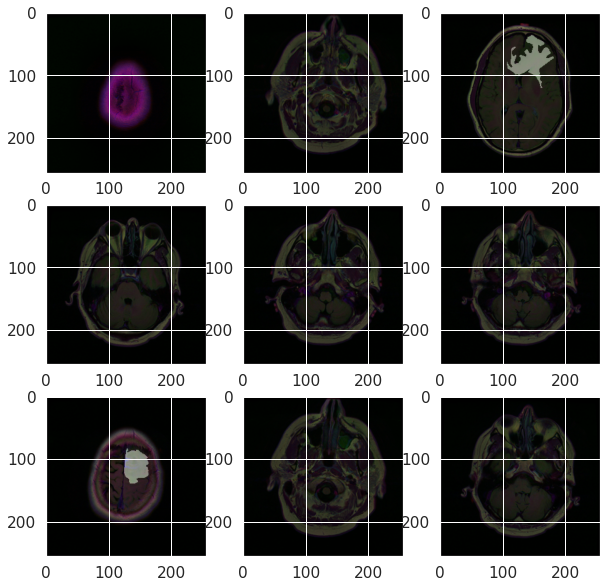

In [11]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

In [12]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})

In [13]:
df.head()

,filename,mask
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...


In [14]:
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)

In [15]:
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


### MODEL
encoder

In [16]:
def conv_block(inputs=None, n_filters=64, max_pooling=True):
    conv = layers.Conv2D(n_filters,
                  kernel_size = (3, 3),
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(inputs)
    conv = layers.Conv2D(n_filters,
                  kernel_size = (3, 3),
                  activation = None,
                  padding = 'same',
                  kernel_initializer = 'he_normal')(conv)
    skip_connection = conv
    conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    if max_pooling:
        next_layer = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(conv)
    else:
        next_layer = conv
    
    return next_layer, skip_connection

decoder

In [17]:
def upsampling_block(expansive_input, contractive_input, n_filters=64):
    up = layers.Conv2DTranspose(
                 n_filters,
                 kernel_size = (2, 2),
                 strides = (2, 2),
                 padding = 'same')(expansive_input)
    
    merge = layers.concatenate([up, contractive_input], axis=3)
    conv = layers.Conv2D(n_filters,
                 kernel_size = (3, 3),
                 activation = 'relu',
                 padding = 'same',
                 kernel_initializer = 'he_normal')(merge)
    conv = layers.Conv2D(n_filters,
                 kernel_size = (3, 3),
                 activation = None,
                 padding = 'same',
                 kernel_initializer = 'he_normal')(conv)
    conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    return conv

complete model

In [18]:
def build_unet(input_size=(256, 256, 3), n_filters=64, n_classes=1):
    
    # Input layer
    inputs = layers.Input(input_size)
    
    # Encoder (double the number of filters at each step)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters)
    cblock5 = conv_block(cblock4[0], 16*n_filters, max_pooling=False) 
    
    # Decoder (halve the number of filters at each step)
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  4*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    # 1x1 convolution
    conv10 = layers.Conv2D(filters = n_classes,
                 kernel_size = (1, 1),
                 activation = 'sigmoid',    # use softmax if n_classes>1
                 padding = 'same')(ublock9)

    model = keras.Model(inputs=inputs, outputs=conv10)

    return model

In [35]:
model=build_unet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_19[0][0]']              
                                )                                                           

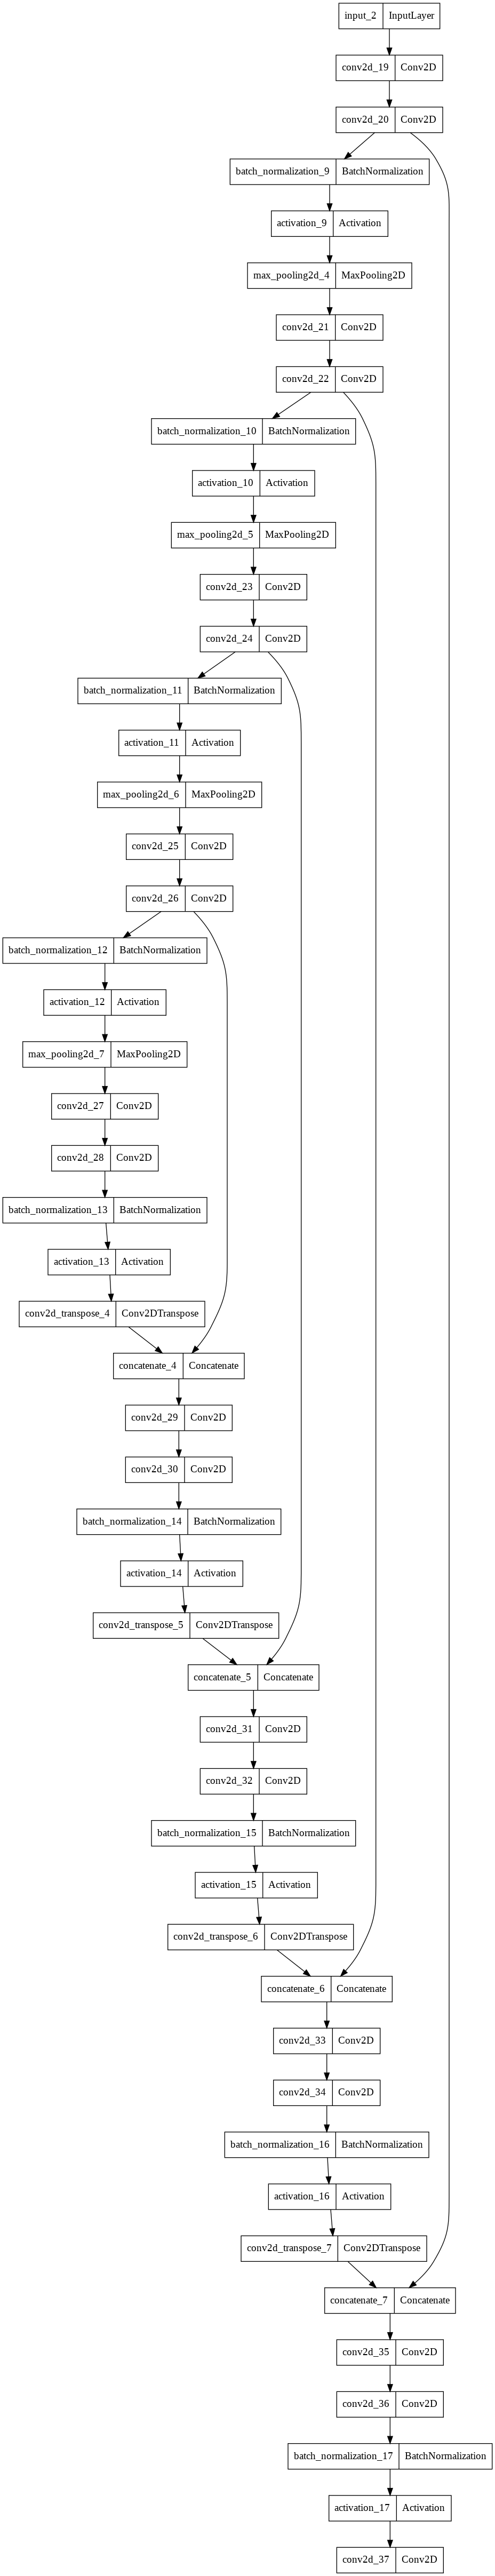

In [36]:
plot_model(model)

In [21]:
def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [22]:
def train_generator(data_frame, batch_size, aug_dict,
                    image_color_mode="rgb",
                    mask_color_mode="grayscale",
                    image_save_prefix="image",
                    mask_save_prefix="mask",
                    save_to_dir=None,
                    target_size=(256,256),
                    seed=1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(data_frame,
                                                        x_col = "filename",
                                                        class_mode = None,
                                                        color_mode = image_color_mode,
                                                        target_size = target_size,
                                                        batch_size = batch_size,
                                                        save_to_dir = save_to_dir,
                                                        save_prefix  = image_save_prefix,
                                                        seed = seed)
    
    mask_generator = mask_datagen.flow_from_dataframe(data_frame,
                                                      x_col = "mask",
                                                      class_mode = None,
                                                      color_mode = mask_color_mode,
                                                      target_size = target_size,
                                                      batch_size = batch_size,
                                                      save_to_dir = save_to_dir,
                                                      save_prefix  = mask_save_prefix,
                                                      seed = seed)
    train_gen = zip(image_generator, mask_generator)
    for (img, mask) in train_gen:
      img, mask = adjust_data(img, mask)
      yield (img,mask)

In [23]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [24]:
EPOCHS = 15
BATCH_SIZE = 32
learning_rate = 1e-3
im_width = 256
im_height = 256

In [25]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

In [26]:
decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

In [27]:
callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

In [28]:
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    #callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/15
89/88 [==============================] - ETA: -1s - loss: 0.8415 - binary_accuracy: 0.9255 - iou: 0.0895 - dice_coef: 0.1588Found 708 validated image filenames.
Found 708 validated image filenames.
88/88 [==============================] - 203s 2s/step - loss: 0.8415 - binary_accuracy: 0.9255 - iou: 0.0895 - dice_coef: 0.1588 - val_loss: 0.9619 - val_binary_accuracy: 0.5361 - val_iou: 0.0188 - val_dice_coef: 0.0366
Epoch 2/15
88/88 [==============================] - 147s 2s/step - loss: 0.5897 - binary_accuracy: 0.9882 - iou: 0.2694 - dice_coef: 0.4123 - val_loss: 0.9239 - val_binary_accuracy: 0.7610 - val_iou: 0.0396 - val_dice_coef: 0.0756
Epoch 3/15
88/88 [==============================] - 146s 2s/step - loss: 0.4102 - binary_accuracy: 0.9921 - iou: 0.4269 - dice_coef: 0.5888 - val_loss: 0.9292 - val_binary_accuracy: 0.7307 - val_iou: 0.0356 - val_dice_coef: 0.0681
Epoch 4/15
88/88 [===============

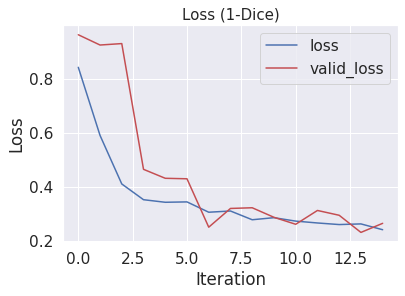

In [29]:
plt.figure(1)
plt.plot(history.history['loss'],'b-', label='loss')
plt.plot(history.history['val_loss'], 'r-', label='valid_loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss (1-Dice)', fontsize = 15)
plt.legend()

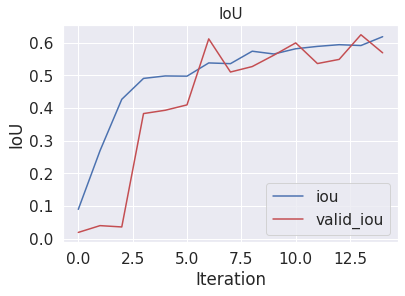

In [30]:
plt.figure(2)
plt.plot(history.history['iou'], 'b-', label='iou')
plt.plot(history.history['val_iou'], 'r-', label='valid_iou')
plt.xlabel('Iteration')
plt.ylabel('IoU')
plt.title('IoU', fontsize = 15)
plt.legend()
plt.show()

In [31]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

In [32]:
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 12s 1s/step - loss: 0.2934 - binary_accuracy: 0.9959 - iou: 0.5438 - dice_coef: 0.6934


In [33]:
print("Test loss: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Test loss:  0.2933960258960724
Test IOU:  0.9959374070167542
Test Dice Coefficent:  0.5438205003738403


1/1 [==============================] - 2s 2s/step


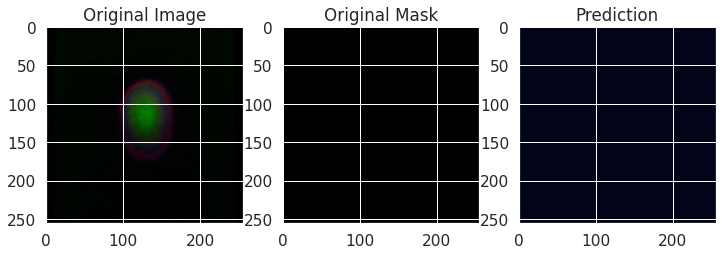

1/1 [==============================] - 0s 17ms/step


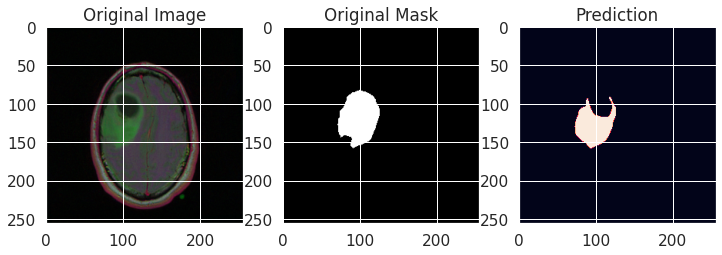

1/1 [==============================] - 0s 17ms/step


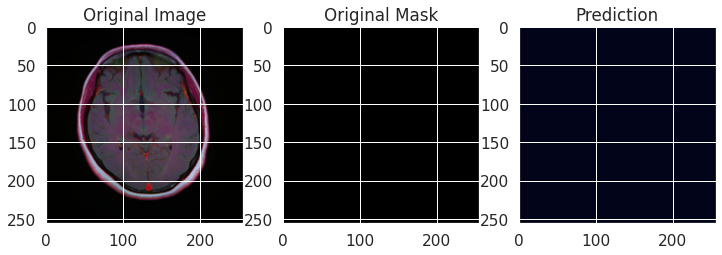

1/1 [==============================] - 0s 18ms/step


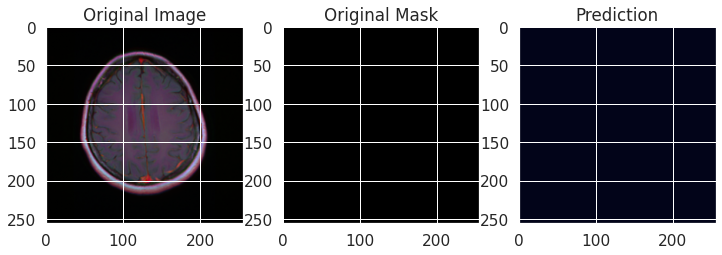

1/1 [==============================] - 0s 17ms/step


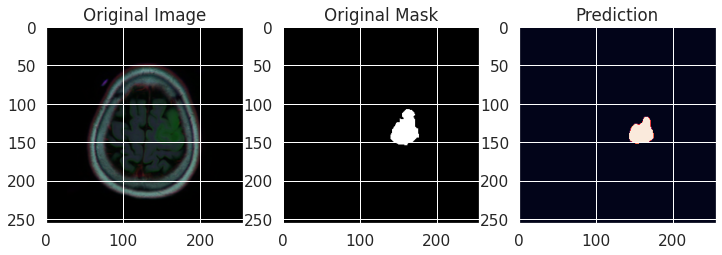

1/1 [==============================] - 0s 18ms/step


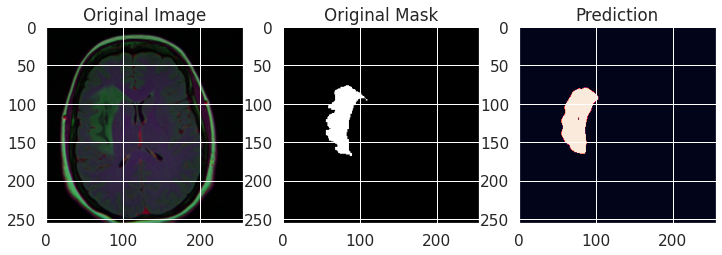

1/1 [==============================] - 0s 17ms/step


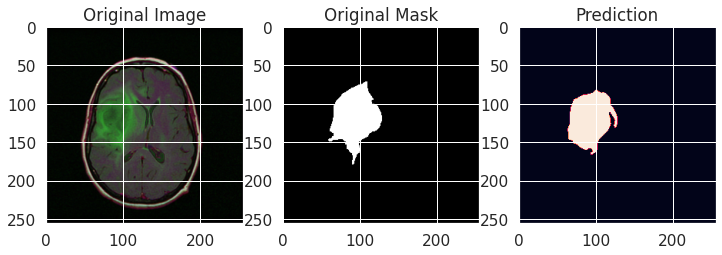

1/1 [==============================] - 0s 19ms/step


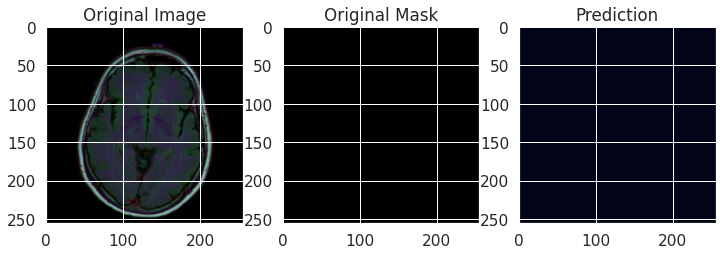

1/1 [==============================] - 0s 19ms/step


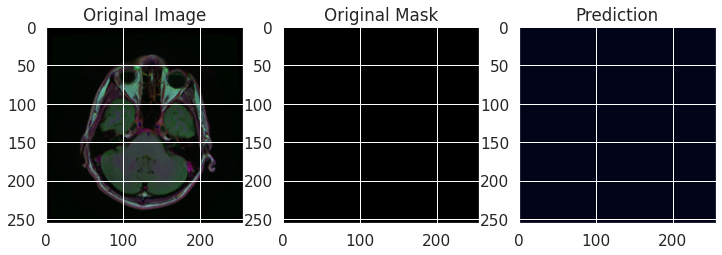

1/1 [==============================] - 0s 17ms/step


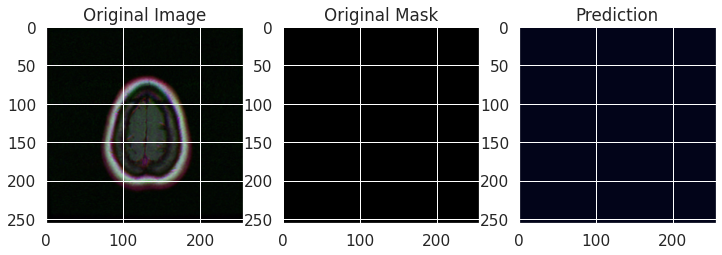

1/1 [==============================] - 0s 17ms/step


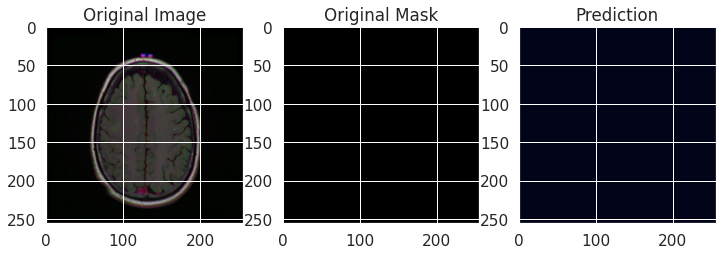

1/1 [==============================] - 0s 19ms/step


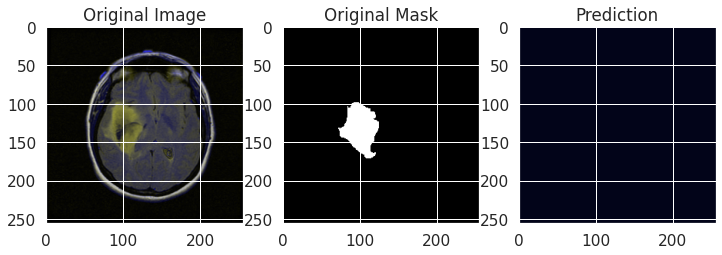

1/1 [==============================] - 0s 18ms/step


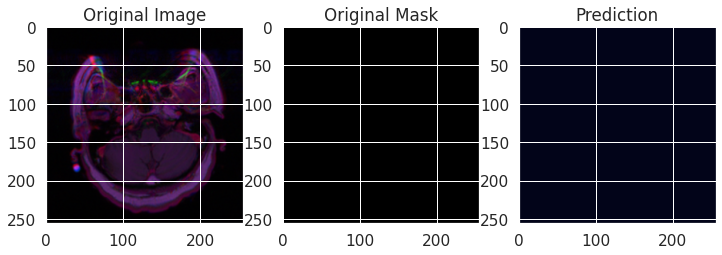

1/1 [==============================] - 0s 18ms/step


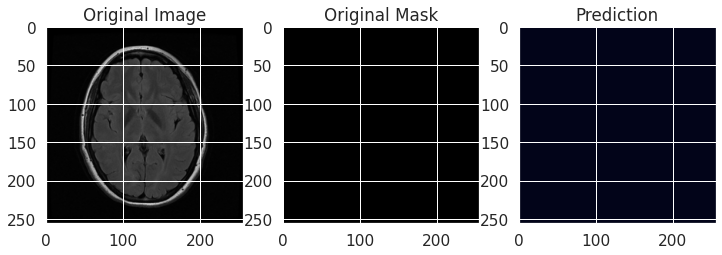

1/1 [==============================] - 0s 19ms/step


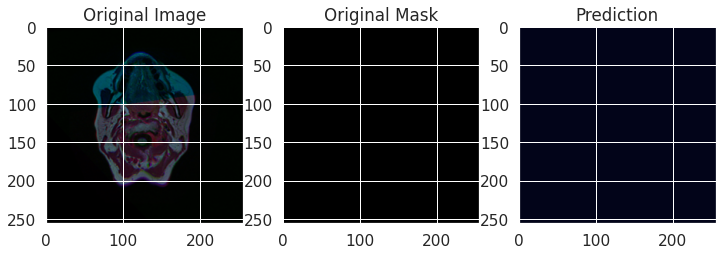

1/1 [==============================] - 0s 17ms/step


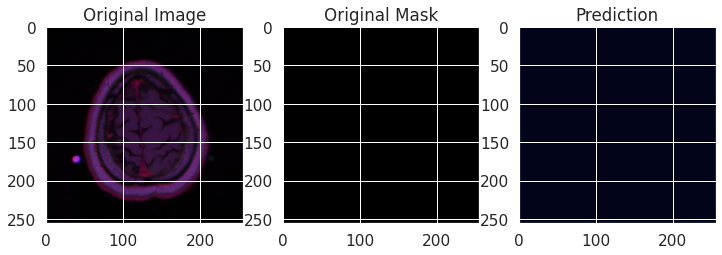

1/1 [==============================] - 0s 18ms/step


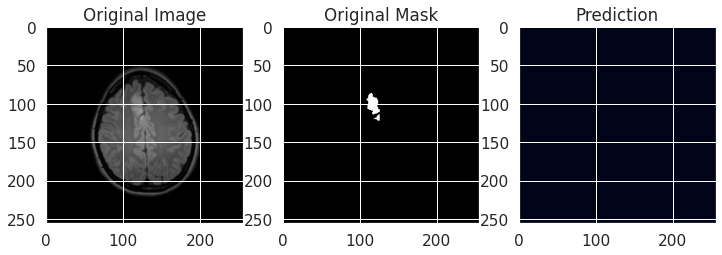

1/1 [==============================] - 0s 18ms/step


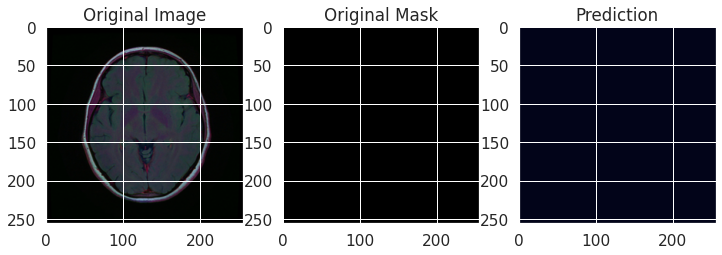

1/1 [==============================] - 0s 17ms/step


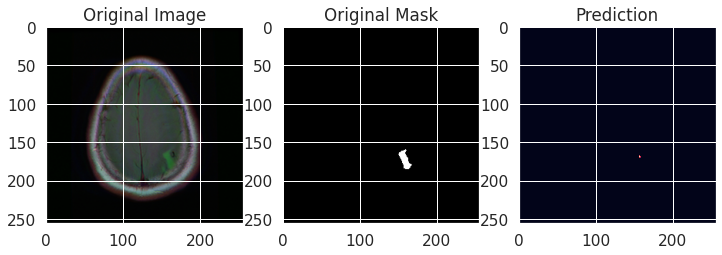

1/1 [==============================] - 0s 17ms/step


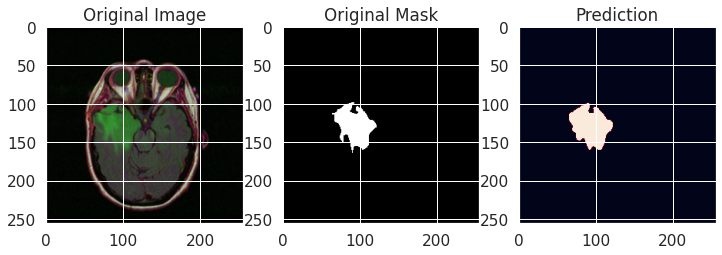

In [34]:
for i in range(20):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()